## Incoherently averaged sky images 
The power spectra estimated by pspipe module will be imaged (by Fourier transformation) 
using only certain part of the power spectra (e.g. the primary beam (< 5 deg delay line), triangular area in red in the Figure) to identify whether the excess in the power spectra comes from a specific source in the sky. <br>
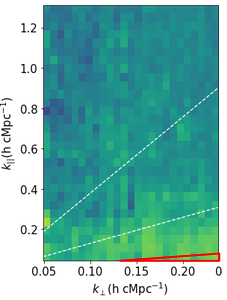

In [21]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm

import numpy as np

from ps_eor import datacube, pspec, fitutil, fgfit, psutil
from pspipe import settings, database


### Load and save processed data

In [23]:
obs_nums = ['L80847',         ## Observation IDs
            'L80850',
            'L196421',
            'L253987',
            'L254116',
            'L254871',
            'L254865',] 

du = 2                        ## Baseline bin size for the cylindrically averaged PS (for FoV =20 deg here)
toml_path='/net/node116/data/users/lofareor/hgan/pspipe/observation_ver2_red2/rev03.toml' ## pspipe setups

angs = [5, 20, 90]

t_labels=['LST00_LST03','LST03_LST06','LST06_LST09','LST09_LST12'] # some labels for file names
folder_labels=['t000','t001','t002','t003']
ang_tags=["<5","5-20" ,"20-90"]
titles=['< 5 deg', '5-20 deg', '20-90 deg']

ft_i_cube_all = []

for i, label2 in enumerate(folder_labels):  ## iterate over 3h-LST bins
    t_label = t_labels[i]
    print("Data saved for "+str(t_label)+ ": ", end = '')
    
    for obs_num in obs_nums:   ## iterate over observations 

        obs=obs_num+'_flagged'  ## process on the flagged data (post processing RFI flagging)
        s = settings.Settings.load_with_defaults(toml_path)  ## load pspipe settings
        rev = database.VisRevision(s)                        ## load a data cube (an observation)
        data= rev.get_data(obs, lst_idx=i)               ## get data from the time slice 
        #data.do_flag() # post processing flagging (uv-coverage etc see config)

        ps_gen = data.get_ps_gen(eor_bin_name='2', ps2d_pos_only=True, window_fct='boxcar') #load a cube with an eor_bin
        ps_gen.eor.M =70   #M : Number of Fourier components computed :to match the cube sizes between nights
        fit_res_i_red2 = data.get_gpr_res('2')  #load the data after GPR from the cube
        ft_i_cube = ps_gen.eor.get_slice(fit_res_i_red2.sub) #load the residual stokes i 
        
        for j, ang in enumerate(angs):   ## iterate over different filters

            el = 2 * np.pi * (np.arange(ft_i_cube.ru.min(), ft_i_cube.ru.max(), du))   
            # calculate l modes (for calculating the power spectra)        
            delay, df_i_cube = psutil.nudft(ft_i_cube.freqs, ft_i_cube.data) # perferm FF on the image cube to k-space
            z = psutil.freq_to_z(ft_i_cube.freqs.mean())  ## calculate the mean redshift
            k_par = psutil.delay_to_k(delay, z)           ## calculate k_par
            #k_per = psutil.l_to_k(el, z)                  ## calculate k_per
            
            #print(k_par.shape, k_per.shape)
            k_per = psutil.l_to_k(2 * np.pi * ft_i_cube.ru, z)

            ## apply filters to the power spectra (in k-space)
            if j==0:
                max_k_pars = psutil.wedge_fct(np.radians(angs[j]), z, k_per)
                mask = np.array([abs(k_par) < w_b for w_b in max_k_pars]).T
                df_i_cube[~mask] = 0     
                ang_tag=ang_tags[j]

            elif j==1 or j==2:
                max_k_pars = psutil.wedge_fct(np.radians(angs[j]), z, k_per)
                mask1 = np.array([abs(k_par) < w_b for w_b in max_k_pars]).T

                min_k_pars = psutil.wedge_fct(np.radians(angs[j-1]), z, k_per)
                mask2 = np.array([abs(k_par) < w_b2 for w_b2 in min_k_pars]).T

                df_i_cube[(~mask1)|mask2] = 0    
                ang_tag=ang_tags[j]
            ## perform FF in k-space back to image space & and calculate RMS along frequency 
            i_cube_data_filtered = np.fft.ifft(df_i_cube, axis=0)
            i_cube_filtered = ft_i_cube.new_with_data(i_cube_data_filtered)
            img_cube = i_cube_filtered.regrid().image()
            data = img_cube.data.real[:]
            imag = np.std(img_cube.data.real[:], axis=0)
            #print(data.shape)
            ## save the filtered image cubes 
            np.save('./new_imag/'+obs_num+'_'+label2+'_'+ang_tag+'.npy', data, allow_pickle=True)
        print("*", end = '')
    print(" Done! ")


Data saved for LST00_LST03******* 
Data saved for LST03_LST06******* 
Data saved for LST06_LST09******* 
Data saved for LST09_LST12******* 


### Image the saved data, average over nights incoherently  

Data incoherently averaged for LST00_LST03
Data incoherently averaged for LST03_LST06
Data incoherently averaged for LST06_LST09
Data incoherently averaged for LST09_LST12


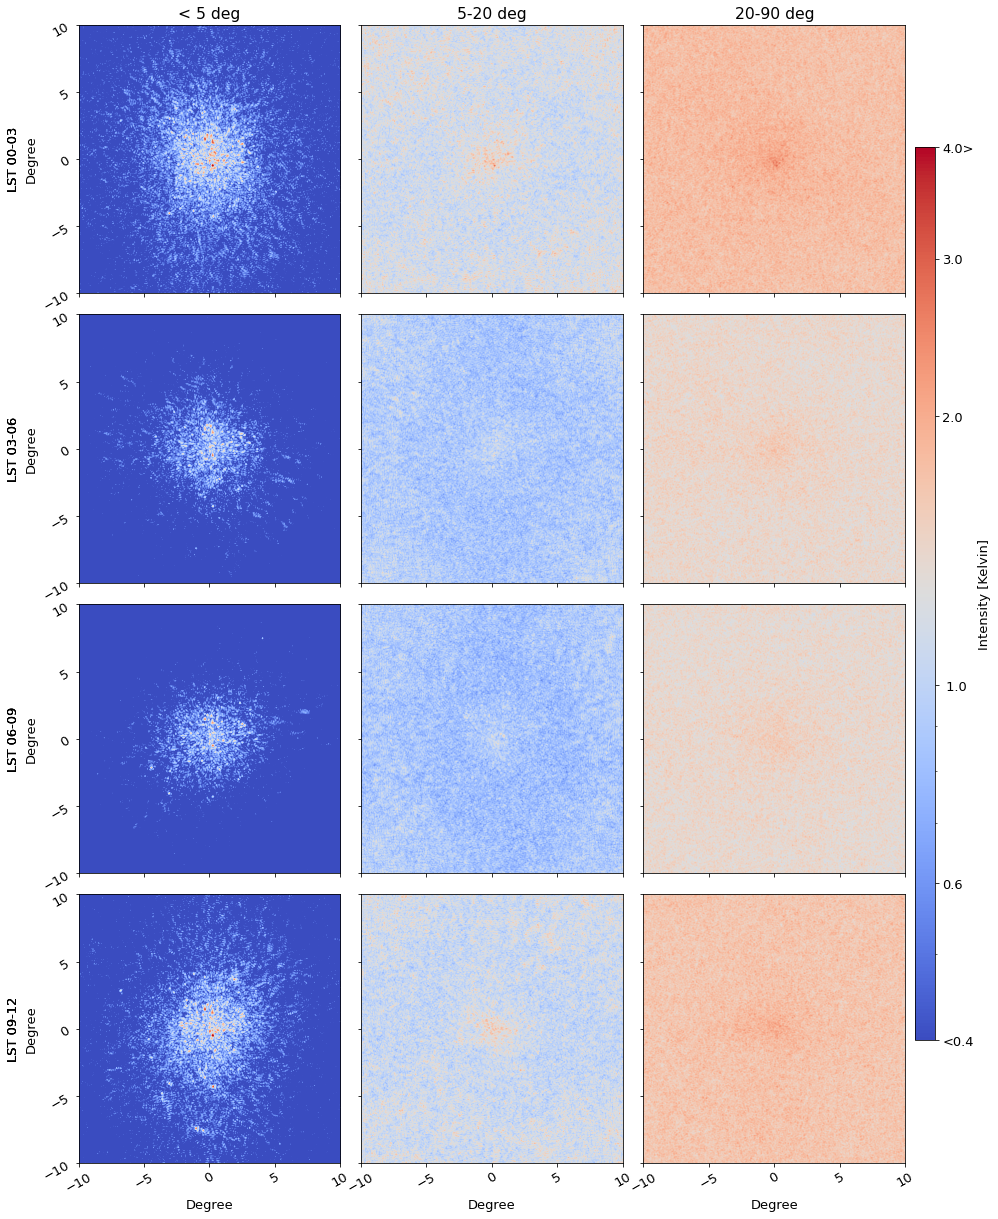

In [24]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(14, 17), sharey=True, sharex=True)
mpl.rcParams.update({'font.size': 13})

obs_nums = ['L80847',
            'L80850',
            'L196421',
            'L253987',
            'L254116',
            'L254871',
            'L254865',]

rows = ['LST {}'.format(row) for row in ['00-03', '03-06', '06-09', '09-12']]

for i, label2 in enumerate(folder_labels):  ## iterate over 3h-LST bins
    t_label = t_labels[i]
   
    for j, ang in enumerate(angs):   ## iterate over different filters
        all_obs = []
        ang_tag = ang_tags[j]
        tmp=[]
        for obs_num in obs_nums[:]:
            tmp = np.load('./new_imag/'+obs_num+'_'+label2+'_'+ang_tag+'.npy', allow_pickle=True)
            tmp = np.std(tmp, axis=0)
            all_obs.append(tmp)
        #print(np.shape(all_obs))
        imag = np.mean(all_obs, axis=0)
        p1=ax[i,j].imshow(imag,aspect='auto', extent=[-10,10,-10,10], norm=LogNorm(), 
                          cmap='coolwarm', clim=(0.4, 4))
        ax[i,j].tick_params(axis='both', which='major', rotation=30)
        ax[0,j].set_title(titles[j])
        ax[3,j].set(xlabel='Degree')
        ax[i,0].set(ylabel='Degree')
        ax[i,0].annotate(rows[i], xy=(0, 0.5), xytext=(-ax[i,0].yaxis.labelpad-0.1, 0),
                xycoords=ax[i,0].yaxis.label, textcoords='offset points',
                #size='small', 
                ha='right', va='center',rotation=90)
        ax[i,0].locator_params(nbins=5, axis='y')
        #print(t_label, ang, i, j)
    print("Data incoherently averaged for "+str(t_label))
cbar_ax1 = fig.add_axes([0.91, 0.14, 0.020, 0.73])
c1=fig.colorbar(p1, cax=cbar_ax1, ticks=[0.4, 0.6, 1., 2, 3, 4])
c1.ax.set_yticklabels(['<0.4','0.6',' 1.0', '2.0','3.0','4.0>']) # vertically oriented colorbar
c1.set_label('Intensity [Kelvin]')

fig.subplots_adjust(wspace=0.08, hspace=0.08, left=0.08, right=0.90, top=.97, bottom=.04)
fig.savefig('./new_imag/Incoherently_averaged_sky_images.pdf')
plt.show()
